# Python 実践データ分析 100本ノック 第2版

(Python Practical Data Analysis 100 Knocks, 2nd ed.)

### 第3部 実践編②：最適化問題

(Part 3: Practice 2: Optimization Problem)

### 第7章 ロジスティクスネットワークの最適設計を行う10本ノック

 (Chapter 07: 10 knocks to optimize the design of logistics networks)

In [1]:
# Connect with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Move to working folder
import os
os.chdir('/content/drive/MyDrive/Colab-Notebooks/python-100knock-data-analytics/chap07/')

### knock 61 : Let's solve a transportation optimization problem.

In [3]:
!pip install pulp
!pip install ortoolpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: pulp
    Found existing installation: PuLP 3.1.1
    Uninstalling PuLP-3.1.1:
      Successfully uninstalled PuLP-3.1.1


In [4]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

In [5]:
df_tc = pd.read_csv('trans_cost.csv', index_col="工場")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# initialization
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

# Mathematical Modeling
m1 = model_min()
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve()

# Total Transportation Cost Calculation
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)

print(df_tr_sol)
print("Total Transportation Cost: "+str(total_cost))

    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
Total Transportation Cost: 1296.0


<ipython-input-5-deacf66c9460>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
<ipython-input-5-deacf66c9460>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
<ipython-input-5-deacf66c9460>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
<ipython-inpu

Compared to the current total transportation cost of 14.33 million yen calculated by Knock 58, it shows a significant cost reduction

### knock 62 : Check the network for the best transportation routes!

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

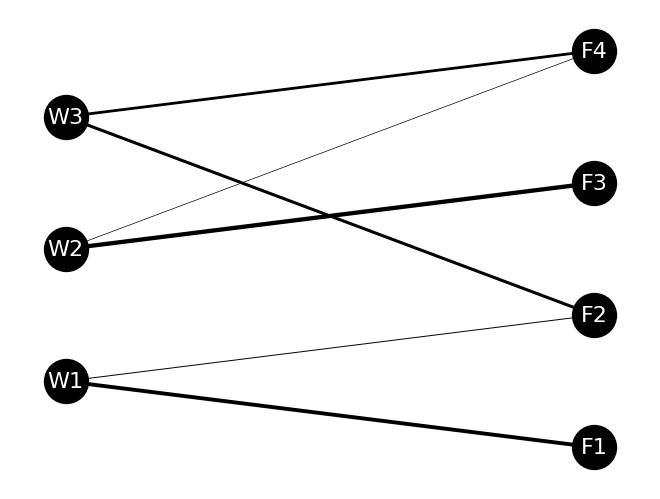

In [7]:
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')

# Creating Graph Objects
G = nx.Graph()

# Vertex Settings
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# Set edges & list edge weights
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # Adding an Edge
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # Adding Edge Weights
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)


# Coordinate setting
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])

nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

plt.show()

From the visualized network, it can be said that the hypothesis “transport routes should be aggregated to some extent” made in Knock 57 is correct, and the optimization or calculation has been clarified.

### knock 63 : Let's check if the optimal transportation route is within the constraints.

In [8]:
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# Constraint Calculation Functions
# demand side
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag

# supply side
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("Demand Condition Calculation Result:"+str(condition_demand(df_tr_sol,df_demand)))
print("Supply Condition Calculation Result:"+str(condition_supply(df_tr_sol,df_supply)))

Demand Condition Calculation Result:[1. 1. 1. 1.]
Supply Condition Calculation Result:[1. 1. 1.]


<ipython-input-8-532cb1165c3a>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (temp_sum>=df_demand.iloc[0][i]):
<ipython-input-8-532cb1165c3a>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if temp_sum<=df_supply.iloc[0][i]:


All constraints on both the demand and supply side indicate 1, indicating that they are satisfied

### knock 64 : Let's read the data related to the production plan.

| No. | File Name | Outline |
|-----------|-----------|-----------|
|  1  | product_plan_material.csv | Percentage of raw materials required to manufacture the product   |
|  2  | product_plan_profit.csv   | Product Profit   |
|  3  | product_plan_stock.csv    | Inventory of raw materials   |
|  4  | product_plan.csv          | Product output   |

In [9]:
df_material = pd.read_csv('product_plan_material.csv', index_col="製品")
print(df_material)
df_profit = pd.read_csv('product_plan_profit.csv', index_col="製品")
print(df_profit)
df_stock = pd.read_csv('product_plan_stock.csv', index_col="項目")
print(df_stock)
df_plan = pd.read_csv('product_plan.csv', index_col="製品")
print(df_plan)

     原料1  原料2  原料3
製品                
製品1    1    4    3
製品2    2    4    1
      利益
製品      
製品1  5.0
製品2  4.0
    原料1  原料2  原料3
項目               
在庫   40   80   50
     生産量
製品      
製品1   16
製品2    0


Despite the fact that the raw materials for Product 2 are being manufactured, Product 2 is not being manufactured.

Increasing the amount of Product 2 manufactured should increase profits.

### knock 65 : Let's create a function to calculate profit.

In [22]:
# Profit Calculation Functions
def product_plan(df_profit,df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
    return profit

print("Total profit:"+str(product_plan(df_profit,df_plan))+ " man yen :"+ str(product_plan(df_profit,df_plan)*10000) +" yen :"+ str((product_plan(df_profit,df_plan)*10000)/1000000) +" million yen")

Total profit:80.0 man yen :800000.0 yen :0.8 million yen


<ipython-input-22-995df0edfec3>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]


### knock 66 : Let's solve a production optimization problem.

In [16]:
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

In [21]:
df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit)) ) <= df_stock.iloc[:,i]
m.solve()

df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("Total profit: "+str(value(m.objective))+ " man yen :"+ str(value(m.objective)*10000) +" yen :"+ str((value(m.objective)*10000)/1000000) +" million yen")

     生産量
製品      
製品1   15
製品2    5
Total profit: 95.0 man yen :950000.0 yen :0.95 million yen


After solving the optimization problem, it was found that by decreasing the production volume of Product 1 by 1 to 15, the production volume of Product 2 could be increased by 5, resulting in an increase in profit to 950,000 yen.

### knock 67 : Let's check if the optimal production plan is within the constraints.

In [39]:
# Constraint Calculation Functions
def condition_stock(df_plan,df_material,df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i]+"  usage volume:"+str(temp_sum)+", inventory:"+str(float(df_stock.iloc[0][i])))
    return flag

print("Constraint Condition Calculation Result:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

原料1  usage volume:25.0, inventory:40.0
原料2  usage volume:80.0, inventory:80.0
原料3  usage volume:50.0, inventory:50.0
Constraint Condition Calculation Result:[1. 1. 1.]


<ipython-input-39-5738c4c26db8>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
<ipython-input-39-5738c4c26db8>:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
<ipython-input-39-5738c4c26db8>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (temp_sum<=float(df_stock.iloc[0][i])):
<ipython-input-39-5738c4c26db8>:10: FutureWarning: Series.__getitem__ treating keys as positions is dep

* All constraints are satisfied in the calculation results.
* Raw materials 2 and 3 are fully utilized with no surplus.
* Raw material 1 has a slight surplus, but utilization is significantly improved compared to before optimization.
* Overall, the improvement is considered reasonable based on the analysis.

### knock 68 : Solve logistics network design problems.

In [46]:
product = list('AB')
demand_site = list('PQ')
factory = list('XY')
lane = (2,2)

# Table of transportation costs
tbdi = pd.DataFrame(((j,k) for j in demand_site for k in factory), columns=['需要地','工場'])
tbdi['輸送費'] = [1,2,3,1]
print(tbdi)

# demand chart
tbde = pd.DataFrame(((j,i) for j in demand_site for i in product), columns=['需要地','製品'])
tbde['需要'] = [10,10,20,20]
print(tbde)

# production schedule
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (factory,lane) for l in range(nl) for i in product),
                    columns=['工場','レーン','製品','下限','上限'])
tbfa['生産費'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'上限']=10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde,tbdi,tbfa)
print(tbfa)
print(tbdi2)

  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  需要地 製品  需要
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  工場  レーン 製品  下限    上限  生産費
0  X    0  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    0  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0
  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000048  20.0
3  X    1  B   0   inf  1.0  v000049  10.0
4  Y    0  A   0  10.0  3.0  v000050  10.0
6  Y    1  A   0   inf  5.0  v000051   0.0
7  Y    1  B   0   inf  3.0  v000052  20.0
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000040  10.0
1   P  X    1  B  v000041  10.0
2   P  Y    2  A  v000042   0.0
3   P  Y    2  B  v000043   0.0
4   Q  X    3  A  v000044  10.0
5   Q  X    3  B  v000045   0.0
6   Q  Y    1  A  v000046  10.0
7   Q  Y    1  B  v000047  20.0


Items created by function logistics_network

ValY : optimum production

ValX : optimum transport volume

Knocks 69 and 70 check whether these results are valid or not.

### knock 69 : Calculate transportation costs and their breakdown in the optimal network!

In [47]:
print(tbdi2)
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["輸送費"].iloc[i]*tbdi2["ValX"].iloc[i]
print("Total Transportation Cost:"+str(trans_cost)+ " man yen :"+ str((trans_cost)*10000) +" yen :"+ str(((trans_cost)*10000)/1000000) +" million yen")

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000040  10.0
1   P  X    1  B  v000041  10.0
2   P  Y    2  A  v000042   0.0
3   P  Y    2  B  v000043   0.0
4   Q  X    3  A  v000044  10.0
5   Q  X    3  B  v000045   0.0
6   Q  Y    1  A  v000046  10.0
7   Q  Y    1  B  v000047  20.0
Total Transportation Cost:80.0 man yen :800000.0 yen :0.8 million yen


* Total production cost: 0.8 million yen.
* Routes used: Factory X → Store P and Factory Y → Store Q.
* These routes transport minimal amounts to meet demand.
* Store Q receives an additional 10 units of Product A from Factory X due to unmet demand.
* Factory Y has limited production capacity.
* Factory X has lower production costs for Product A.
* The chosen transportation and production strategy appears efficient and cost-effective.

### knock 70 : Let's calculate the production cost and its breakdown in the optimal network

In [36]:
print(tbfa)
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["生産費"].iloc[i]*tbfa["ValY"].iloc[i]
print("Total production cost:"+str(product_cost)+ " man yen :"+ str((product_cost)*10000) +" yen :"+ str(((product_cost)*10000)/1000000) +" million yen")

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000022  20.0
3  X    1  B   0   inf  1.0  v000023  10.0
4  Y    0  A   0  10.0  3.0  v000024  10.0
6  Y    1  A   0   inf  5.0  v000025   0.0
7  Y    1  B   0   inf  3.0  v000026  20.0
Total production cost:120.0 man yen :1200000.0 yen :1.2 million yen


* Total production cost: 1.2 million yen.
* Factory X produces 20 units of Product A and 10 units of Product B due to its lower production costs.
* Ideally, all production would occur at Factory X to minimize production costs.
* However, due to transportation costs, Factory Y must operate to supply Store Q efficiently.
* Factory Y produces 10 units of Product A and 20 units of Product B.
* Overall, the production and distribution plan balances production and transportation costs effectively.

### Use pulp library

In [52]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Data setup
products = list('AB')
demand_sites = list('PQ')
factories = list('XY')

transport_costs = pd.DataFrame([
    ('P', 'X', 1), ('P', 'Y', 2),
    ('Q', 'X', 3), ('Q', 'Y', 1)
], columns=['Demand Site', 'Factory', 'Transportation Cost'])

demand = pd.DataFrame([
    ('P', 'A', 10), ('P', 'B', 10),
    ('Q', 'A', 20), ('Q', 'B', 20)
], columns=['Demand Site', 'Product', 'Demand'])

production = pd.DataFrame([
    ('X', 0, 'A', 0, float('inf'), 1),
    ('X', 1, 'B', 0, float('inf'), 1),
    ('Y', 0, 'A', 0, 10, 3),
    ('Y', 1, 'A', 0, float('inf'), 5),
    ('Y', 1, 'B', 0, float('inf'), 3)
], columns=['Factory', 'Lane', 'Product', 'Lower Limit', 'Upper Limit', 'Production Cost'])

# Replace infinite upper limits with large finite number
production['Upper Limit'] = production['Upper Limit'].replace(float('inf'), 1e10)

# Initialize model
model = LpProblem("LogisticsOptimizationWithLanes", LpMinimize)

# Decision variables: shipment amount from (Factory, Lane) to Demand Site per Product
ship_vars = {}
for _, d_row in demand.iterrows():
    for _, p_row in production.iterrows():
        if d_row['Product'] == p_row['Product']:
            key = (p_row['Factory'], p_row['Lane'], d_row['Demand Site'], d_row['Product'])
            ship_vars[key] = LpVariable(f"Ship_{key[0]}_{key[1]}_{key[2]}_{key[3]}", lowBound=0)

# Objective: minimize total cost = production cost + transportation cost
terms = []
for key, var in ship_vars.items():
    factory, lane, demand_site, product = key
    # Find production cost for this factory-lane-product
    prod_cost = production[
        (production['Factory'] == factory) &
        (production['Lane'] == lane) &
        (production['Product'] == product)
    ]['Production Cost'].values[0]
    # Find transportation cost for factory-demand_site
    trans_cost_row = transport_costs[
        (transport_costs['Factory'] == factory) &
        (transport_costs['Demand Site'] == demand_site)
    ]
    if trans_cost_row.empty:
        continue
    trans_cost = trans_cost_row['Transportation Cost'].values[0]
    terms.append((prod_cost + trans_cost) * var)
model += lpSum(terms)

# Demand constraints: total shipments to demand site per product satisfy demand
for _, d_row in demand.iterrows():
    model += lpSum([
        ship_vars[(p_row['Factory'], p_row['Lane'], d_row['Demand Site'], d_row['Product'])]
        for _, p_row in production.iterrows()
        if p_row['Product'] == d_row['Product']
    ]) == d_row['Demand'], f"Demand_{d_row['Demand Site']}_{d_row['Product']}"

# Production capacity constraints: sum shipments from each factory-lane-product ≤ upper limit
for _, p_row in production.iterrows():
    model += lpSum([
        ship_vars[(p_row['Factory'], p_row['Lane'], d_row['Demand Site'], p_row['Product'])]
        for _, d_row in demand.iterrows()
        if d_row['Product'] == p_row['Product']
    ]) <= p_row['Upper Limit'], f"Capacity_{p_row['Factory']}_{p_row['Lane']}_{p_row['Product']}"

# Solve model
model.solve()

# Output results
print("Status:", LpStatus[model.status])
print("\nShipment plan:")
if LpStatus[model.status] == 'Optimal':
    for var in model.variables():
        val = value(var)
        if val > 0:
            print(f"{var.name} = {val}")
else:
    print("No optimal solution found.")

print("\nTotal Cost:", value(model.objective))

Status: Optimal

Shipment plan:
Ship_X_0_P_A = 10.0
Ship_X_0_Q_A = 20.0
Ship_X_1_P_B = 10.0
Ship_X_1_Q_B = 20.0

Total Cost: 200.0
